In [39]:
import os
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
import colorsys
import json

print(os.path.exists("cube.obj")) 

True


In [40]:
mi.set_variant('llvm_ad_rgb')
# mi.set_variant('scalar_rgb')

scale = 0.28

def light_grid(face, n1, n2, const_val):
    positions = []
    half = scale / 2
    if face == "top":
        xs = np.linspace(-scale, scale, n1)
        zs = np.linspace(-scale, scale, n2)
        for x in xs:
            for z in zs:
                positions.append((face, [x, const_val, z]))
    elif face == "back":
        xs = np.linspace(-scale, scale, n1)
        ys = np.linspace(-scale, scale, n2)
        for x in xs:
            for y in ys:
                positions.append((face, [x, y, const_val]))
    elif face == "left" or face == "right":
        ys = np.linspace(-scale, scale, n1)
        zs = np.linspace(-scale, scale, n2)
        for y in ys:
            for z in zs:
                positions.append((face, [const_val, y, z]))

    return positions


def get_light_color(face, config_name):
    with open('color_configs.json') as f:
        color_configs = json.load(f)

    if config_name not in color_configs:
        raise ValueError(f"Configuration '{config_name}' not found in color_configs.json")
    config = color_configs[config_name]

    color = config.get(face, [0, 0, 0])

    return color

configs = json.load(open("color_configs.json"))
print(configs.keys())


dict_keys(['RGB', 'CMYK', 'GRAY', 'WHITE', 'WARM', 'COOL', 'RAINBOW', 'NEON', 'PASTEL', 'SIDES', 'TOP'])


In [41]:
# 10 x 15 = 150 lights per face

# CONST = 0.22
CONST = (scale / 2) + (scale / 5)
left_pos  = light_grid("left",  10, 15, -CONST)  
top_pos   = light_grid("top",   10, 15,  CONST)   
back_pos  = light_grid("back",  10, 15, -CONST)  
right_pos = light_grid("right", 10, 15,  CONST)   

# all_pos = top_pos + back_pos + left_pos + right_pos
all_pos = left_pos + top_pos + back_pos + right_pos

In [42]:
num_emitters = len(all_pos)
print(f"Number of emitters: {num_emitters}")
emitters = {}

CONFIG = "RGB"

for i, (face, pos) in enumerate(all_pos):
    color = get_light_color(face, CONFIG)

    # intensity = 0.0005 if face == "top" else 0.08
    # intensity = 0.08
    intensity = 0.001
    # intensity = 1
    # if face == 'top':
    #     intensity = 0.3

    color = [intensity * c for c in color]
    emitters[f"light_{i}"] = {
        "type": "point",
        "position": pos,
        "intensity": {
            "type": "rgb",
            "value": color
        }
    }

Number of emitters: 600


In [43]:
for key, val in emitters['light_0'].items():
    print( f"{key}: {val}")

def idx_to_face(idx):
    if idx < 150:
        return "left"
    elif idx < 300:
        return "top"
    elif idx < 450:
        return "back"
    elif idx < 600:
        return "right"
    else:
        return None
    
def update_emitters(emitters, translation, scale, orientation, faces_on = ["left", "top", "back", "right"]):
    x, y, z = translation
    s = scale
    x_r, y_r, z_r = orientation

    transform = (
        mi.ScalarTransform4f()
        .translate([x, y, z])
        .rotate([1, 0, 0], x_r)
        .rotate([0, 1, 0], y_r)
        .rotate([0, 0, 1], z_r)
        .scale(s)
    )

    # for light in emitters.values():
    #     orig_pos = light["position"]
    #     new_pos = transform @ mi.Point3f(orig_pos)
    #     light["position"] = new_pos

    # return

    updated_emitters = {}

    for name, light in emitters.items():
        idx = int(name.split("_")[1])
        face = idx_to_face(idx)
        orig_pos = light["position"]
        new_pos = transform @ mi.ScalarPoint3f(orig_pos)

        if face in faces_on: 
            updated_emitters[name] = {
                **light,
                "position": new_pos
            }
        else:
            updated_emitters[name] = {
                **light,
                "position": new_pos,
                "intensity": {
                    "type": "rgb",
                    "value": [0, 0, 0]  # turn off the light
                }
            }

    return updated_emitters





type: point
position: [-0.196, -0.28, -0.28]
intensity: {'type': 'rgb', 'value': [0.0, 0.001, 0.0]}


In [44]:
def render_scene(emitters, config="RGB", save_path=None):
    scene_dict = {
        "type": "scene",
        "integrator": {"type": "path"},
        "sensor": {
            "type": "perspective",
            "sampler": {"type": "independent", "sample_count": 512},
            "to_world": mi.ScalarTransform4f().look_at(
                origin=[0, 0.5, 0.8], target=[0, -5, 0], up=[0, 1, 0]
            ),
            "film": {
                "type": "hdrfilm",
                "width": 800,
                "height": 600,
                "pixel_format": "rgb"
            },
        },
        # remove env lighting for point-light scene
        # "env": {
        #     "type": "constant",
        #     "radiance": {"type": "rgb", "value": [0.01, 0.01, 0.01]}
        # },
        "checkerboard": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f()
                .translate([0, 0, 0])      # Place it on the ground
                .rotate([1, 0, 0], -90)      # Lie flat on XZ
                .scale([0.2, 0.2, 1]),       # 0.2 m × 0.2 m plane
            "bsdf": {
                "type": "diffuse",
                "reflectance": {
                    "type": "checkerboard",
                    "color0": { "type": "rgb", "value": [1,1,1] },
                    "color1": { "type": "rgb", "value": [0,0,0] },
                    "to_uv": mi.ScalarTransform4f().scale([10, 10, 1])
                    # 10 checks across ⇒ each check is 0.2 m / 10 = 0.02 m
                }
            }
        }
    }

    scene_dict.update(emitters)

    scene = mi.load_dict(scene_dict)
    img = mi.render(scene)
    bitmap = mi.util.convert_to_bitmap(img)

    if save_path:
        plt.imshow(bitmap)
        plt.axis('off')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    else:
        plt.imshow(bitmap)
        plt.axis('off')
        plt.show()

    return scene_dict

def create_hdri_ref(base_scene_dict, hdri_path):
    # hdri = mi.Bitmap(hdri_path).convert(
    #     mi.Bitmap.PixelFormat.RGB,
    #     mi.Struct.Type.Float32,
    #     srgb_gamma=False
    # )
    scene_dict = base_scene_dict.copy()

    scene_dict["integrator"] = {
        "type": "path",
        "hide_emitters": True  
    }
    scene_dict["emitter"] = {
        "type": "envmap",
        "filename": hdri_path,
    }

    scene = mi.load_dict(scene_dict)
    img = mi.render(scene)
    bitmap = mi.util.convert_to_bitmap(img)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(bitmap)

    return img


    


In [45]:
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree
import mitsuba as mi
import numpy as np

def apply_hdri(hdri_path, emitters, all_pos, n_clusters=600, scale_factor=500.0):

    hdri = mi.Bitmap(hdri_path).convert(
        mi.Bitmap.PixelFormat.RGB,
        mi.Struct.Type.Float32,
        srgb_gamma=False
    )
    hdri_np = np.array(hdri)
    H, W, _ = hdri_np.shape

    # perceived brightness of each pixel in HDRI
    # https://stackoverflow.com/questions/596216/formula-to-determine-perceived-brightness-of-rgb-color
    luminance = (
        0.2126 * hdri_np[:, :, 0] +
        0.7152 * hdri_np[:, :, 1] +
        0.0722 * hdri_np[:, :, 2]
    )

    # hdri lighting is spherical, get pixel directions
    phi   = np.linspace(0, 2 * np.pi, W, endpoint=False)
    theta = np.linspace(0, np.pi, H)
    phi_grid, theta_grid = np.meshgrid(phi, theta)

    # https://en.wikipedia.org/wiki/Spherical_coordinate_system
    dirs = np.stack([
        np.sin(theta_grid) * np.sin(phi_grid), 
        np.cos(theta_grid),
        np.sin(theta_grid) * np.cos(phi_grid)
    ], axis=-1)


    dirs_flat = dirs.reshape(-1, 3)
    colors_flat = hdri_np.reshape(-1, 3)
    weights = luminance.reshape(-1)

    valid = weights > 1e-6
    sample_dirs = dirs_flat[valid]
    sample_colors = colors_flat[valid]
    sample_weights = weights[valid]

    # cluster env lighting into 600 lights
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(sample_dirs, sample_weight=sample_weights)
    cluster_dirs = kmeans.cluster_centers_

    labels = kmeans.labels_
    cluster_colors = np.zeros((n_clusters, 3))
    for i in range(n_clusters):
        cluster_colors[i] = np.average(
            sample_colors[labels == i],
            axis=0,
            weights=sample_weights[labels == i] + 1e-6
        )

    emitter_dirs = np.array([np.array(pos)/np.linalg.norm(pos) for pos in all_pos])
    tree = cKDTree(emitter_dirs)
    _, nearest_indices = tree.query(cluster_dirs)

    for i in range(len(all_pos)):
        emitters[f"light_{i}"]["intensity"]["value"] = [0.0, 0.0, 0.0]

    from collections import defaultdict
    emitter_colors = defaultdict(list)
    for i, emitter_idx in enumerate(nearest_indices):
        emitter_colors[emitter_idx].append(cluster_colors[i])

    for idx, colors in emitter_colors.items():
        avg_color = (np.mean(colors, axis=0) * scale_factor).tolist()
        emitters[f"light_{idx}"]["intensity"]["value"] = avg_color

    return emitters


In [46]:
import matplotlib.pyplot as plt

def plot_emitter_luminance(emitters, all_pos, title="Emitter Intensity Heatmap"):
    values = []
    for i in range(len(all_pos)):
        rgb = np.array(emitters[f"light_{i}"]["intensity"]["value"])
        lum = 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]
        values.append(lum)

    values = np.array(values)
    values = values.reshape(4, 10, 15)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    face_names = ['left', 'top', 'back', 'right']
    for i in range(4):
        im = axs[i].imshow(values[i], cmap='inferno', origin='lower')
        axs[i].set_title(face_names[i])
        axs[i].axis('off')
        fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)

    plt.suptitle(title, fontsize=16)
    plt.show()


In [47]:
# e1 = apply_hdri("../sample_hdri.exr", emitters, [pos for _, pos in all_pos])
# plot_emitter_luminance(e1, [pos for _, pos in all_pos], title="Sample HDRI Mapped")

# e2 = apply_hdri("../night_hdri.exr", emitters, [pos for _, pos in all_pos])
# plot_emitter_luminance(e2, [pos for _, pos in all_pos], title="Night HDRI Mapped")

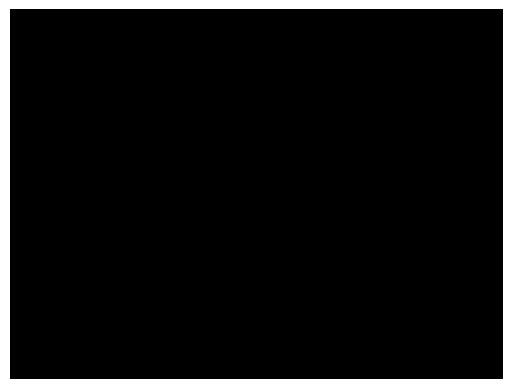

In [48]:
sd = render_scene(emitters, save_path=None)

In [ ]:
sample_ref = create_hdri_ref(sd, "../sample_hdri.exr")
e1 = apply_hdri("../sample_hdri.exr", emitters, [pos for _, pos in all_pos])
sample_mapped = render_scene(e1, save_path=None)

# night_ref = create_hdri_ref(sd, "../night_hdri.exr")
# e2 = apply_hdri("../night_hdri.exr", emitters, [pos for _, pos in all_pos])
# night_mapped = render_scene(e2, save_path=None)

/opt/miniconda3/envs/mitsuba_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
